In [1]:
from options import Options
from lib.data.dataloader import load_data
from lib.models import load_model
import cv2, os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# disable latex error
# plt.rcParams.update({
#     "text.usetex": False,
# })
!pwd

/mnt/c/Users/dndlssardar/OneDrive - Smiths Group/Documents/Soumen/skip-ganomaly


In [2]:
output_dir = 'output/sixray_sd3_greyscale_50epoch'
algorithm_name = 'ganomaly'
experiment_name = 'sixray_sd3' 
data_path = 'dataset/sample'
dataset_name = 'sixray_sd3'
phase = 'test'
device = 'cpu'
imsize = 256
max_epoch = 50
checkpoint = os.path.join(output_dir, 'final')
nc = 1
class Option:
    def __init__(self):
        self.dataset=dataset_name
        self.dataroot=data_path      
        self.patht=''
        self.batchsize=1
        self.workers=8
        self.droplast=False
        self.isize=imsize
        self.nc=nc
        self.nz=100
        self.ngf=64
        self.ndf=64
        self.extralayers=0
        self.device=device
        self.gpu_ids=[0]
        self.ngpu=1
        self.name= experiment_name
        self.model = algorithm_name
        self.display_server="http://localhost"
        self.display_port=8097
        self.display_id=0,
        self.display=False
        self.verbose= False
        self.outf='./output'
        self.manualseed=47
        self.abnormal_class=''
        self.metric='roc'

        ##
        # Train
        self.print_freq=100
        self.save_image_freq=100
        self.save_test_images=False
        self.load_weights=False
        self.resume = checkpoint
        self.phase=phase
        self.iter=0
        self.niter=15
        self.niter_decay=100
        self.beta1=0.5
        self.lr=0.0002
        self.w_adv=1
        self.w_con=50
        self.w_lat=1
        self.lr_policy='lambda'
        self.lr_decay_iters=50

        self.isTrain = False

opt = Option()

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets

def render_histogram(csv_file):
    print(csv_file)
    score_df = pd.read_csv(csv_file)
    
    plt.ion()
    # Filter normal and abnormal scores.
    abn_scr = score_df.loc[score_df.labels == 1]['scores']
    nrm_scr = score_df.loc[score_df.labels == 0]['scores']
    
    # Create figure and plot the distribution.
    sns.distplot(nrm_scr, label=r'Normal Scores', bins=10)
    sns.distplot(abn_scr, label=r'Abnormal Scores', bins=10)
    
    plt.legend()
    plt.yticks([])
    plt.xlabel(r'Anomaly Scores')
    # plt.show(block=True)
    plt.show()

csv_files = [(file, os.path.join(output_dir, file)) for file in os.listdir(output_dir) if file.endswith(".csv")]
if len(csv_files):
    w = widgets.Dropdown(
        options=csv_files,
        description='Select File:',
        disabled=False,
    )
    # o = widgets.Output()
    w.observe(render_histogram)#, o)
    display(w)

Dropdown(description='Select File:', options=(('anomaly_score-epoch-0.csv', 'output/sixray_sd3_greyscale_50epo…

In [4]:
# input = 127.0
# mean = 0.5
# std = 0.06
# # normalize
# norm = (input - mean) / std
# # inverse normalize
# orig = (norm * std) + mean
# norm, round(orig, 5)==round(input, 5), orig, input

In [5]:
def tensor_to_cv(tensor_img):
    np_img = np.moveaxis(tensor_img.numpy(), 0, -1)
    return np_img

def inverse_normalize_tensor(tensor_img, mean, std):
    """
    This is an in-place inverse-normalization algorithm
    Inverse-Normalized = (input * std) + mean
    """
    np_img = tensor_to_cv(tensor_img)
    # print("shapes", tensor_img.shape, np_img.shape)
    func = lambda i, m, s: (i * s) + m
    for ch in range(np_img.shape[2]):
        np_img[:,:,ch] = func(np_img[:,:,ch], mean[ch], std[ch])
    return np_img

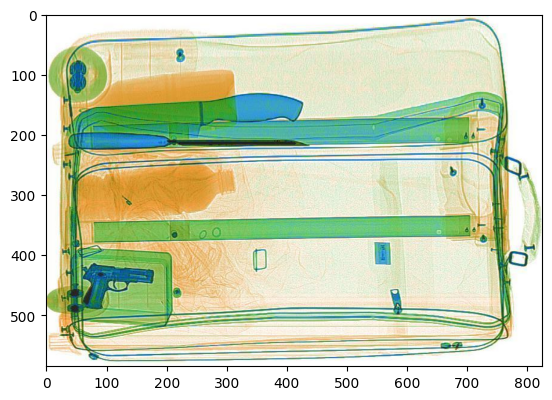

In [6]:
"dataset/sample/train/0.normal/P00080.jpg"
img = cv2.imread("dataset/sample/train/0.normal/P00059.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Input shape: torch.Size([1, 256, 256])


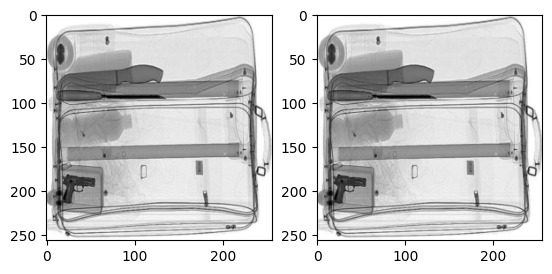

In [7]:
from PIL import Image
from lib.data.sixray_sd3_anomaly_dataset import get_transforms
from torchvision import transforms
import numpy as np
# conver cv to PIL
pil_im = Image.fromarray(img)
# transform
X = get_transforms((imsize, imsize), nc)(pil_im)
print("Input shape:", X.shape)
# inverse transform
np_img = inverse_normalize_tensor(X, (0.5,0.5,0.5),(0.5,0.5,0.5))
# show image
plt.subplot(1,2,1)
plt.imshow(np_img, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(tensor_to_cv(X), cmap="gray")
plt.show()

In [8]:
# load data
data = load_data(opt)
len(data.train)

Dataset Length:
Train Size:  14
Test Size:  25


14

In [9]:
# load pretrained model
model = load_model(opt, None)


Loading pre-trained networks.


FileNotFoundError: [Errno 2] No such file or directory: 'output/sixray_sd3_greyscale_50epoch/final/netG.pth'

In [ ]:
# forward pass thru generator
fakeX_batch= model.netg(X.reshape(1, nc, imsize, imsize))[0].data
# inverse-normalize the generated image to RGB domain
np_img_fake = inverse_normalize_tensor(fakeX_batch[0], (0.5,0.5,0.5),(0.5,0.5,0.5))

inp_x = tensor_to_cv(X)
plt.subplot(1, 2, 1)
plt.imshow(inp_x, cmap="gray" )

plt.subplot(1, 2, 2)
plt.imshow(np_img_fake, cmap="gray" )
plt.show()

In [ ]:
# Compute the absolute difference between the two images
abs_diff = cv2.absdiff(np_img_fake, inp_x)

# Normalize the absolute difference to the range [0, 255]
abs_diff_normalized = cv2.normalize(abs_diff, None, 0, 255, cv2.NORM_MINMAX)

# Optionally, threshold the normalized difference to emphasize dissimilar regions
threshold = 100
_, dissimilarity_mask = cv2.threshold(abs_diff_normalized, threshold, 255, cv2.THRESH_BINARY)

plt.imshow(abs_diff_normalized , cmap="gray")
plt.show()